# Make a Survey Overview

**Goal**: Make a nice DEM overview raster using the dem

**Approach**: 
1. Create an Overview Raster with HillShade
2.  Grab all pit locations

## Process:

### Step 1. Create an Overview Raster with HillShade

In [1]:
from snowxsql.db import get_db
from snowxsql.data import ImageData, LayerData, PointData, SiteData 
from snowxsql.conversions import raster_to_rasterio
from rasterio.plot import show
from sqlalchemy.sql import func
from geoalchemy2.types import Raster
import geoalchemy2.functions as gfunc
import time 
import matplotlib.pyplot as plt 
import geopandas as gpd
from shapely.geometry import Polygon
from geoalchemy2.shape import from_shape, to_shape

# Connect to the database we made.
db_name = 'snowex'
engine, session = get_db(db_name)

data_name = 'snow off digital elevation model'
surveyors = 'USGS'
res = 20

# Form a polygon to clip at the max extent (figured out in advance)
x1 = 735200.0
x2 = 760000.0
y1 = 4319989.0
y2 = 4329803.0
extent = Polygon([[x1, y1], [x1, y2], [x2, y2], [x2, y1]])       # Construct it using shapely

# Make it usable to the db
extent_ewkt = from_shape(extent, srid=26912).ST_AsEWKT()        # Save one for the database
extent_df = gpd.GeoDataFrame({'geometry':[extent]})     # Save one for plotting

# Define a function to reduce the same code used for getting the dem and hillshade
def filter_and_return(session, base, data_name, surveyors, extent):
    '''
    Small function to apply redundent filters and raster making
    '''
    q = session.query(func.ST_AsTiff(func.ST_Clip(base, extent)))
    q = q.filter(ImageData.type == data_name)
    q = q.filter(ImageData.surveyors == surveyors)
    rasters = q.all()
    dataset = raster_to_rasterio(session, rasters)[0]
    return dataset

# Create the base query to reduce code 
bq = func.ST_Rescale(ImageData.raster, res, -1 * res, 'blinear')

# Retrieve the dem
base = gfunc.ST_Union(bq, type_=Raster)
dem = filter_and_return(session, base, data_name, surveyors, extent_ewkt)

# Retrieve the hillshade
base = func.ST_Hillshade(gfunc.ST_Union(bq, type_=Raster))
hillshade = filter_and_return(session, base, data_name, surveyors, extent_ewkt)

### Step 2. Grab locations of single location type data

In [2]:
# Write a simple function to retrieve positional points of data
def grab_points(session, TableClass, data_name, distinct=False, instrument=None):
    '''
    Returns a dataframe of geometric points
    '''
    q = session.query(TableClass.geom).filter(TableClass.type == data_name)
    
    if instrument != None:
        q = q.filter(TableClass.instrument == instrument)
    
    if distinct:
        q = q.distinct()
    
    points = q.all()
    
    # Make the points useable in plotting
    df = gpd.GeoDataFrame({'geometry':[to_shape(p[0]) for p in points]})
    print('Found {} points for {}...'.format(len(df.index), data_name))
    return df

In [3]:
# Grab our pits by selecting hand hardness profiles
data = {}

pits = grab_points(session, LayerData, 'hand_hardness', distinct=True)
smp = grab_points(session, LayerData, 'force', distinct=True)

depths = grab_points(session, PointData, 'depth', instrument='magnaprobe')
gpr = grab_points(session, PointData, 'two_way_travel')

Found 167 points for hand_hardness...
Found 807 points for force...
Found 33364 points for depth...
Found 12651 points for two_way_travel...


### Step 3. Grab centroids of all the raster tiles

In [4]:
# Define a function to grab the center of each raster tile
def get_tile_centers(session, data_name, surveyors=None):
    '''
    Simple function to grab the center of each tile given a data type and optionally a surveyor name
    '''
    # Use database to grab the centroid of each tile outline (envelope) filtering on type. Also return the surveyor.
    q = session.query(func.ST_Centroid(func.ST_Envelope(ImageData.raster))).filter(ImageData.type == data_name)
    
    # If surveyors is provided, filter on that too
    if surveyors != None:
        q = q.filter(ImageData.surveyors == surveyors)
    
    centers = q.all()
    
    # Form the data into useable python jazz
    df = gpd.GeoDataFrame({'geometry':[to_shape(p[0]) for p in centers]})
    print('Found {} tiles for {}...'.format(len(df.index), data_name))
    return df

In [30]:
# Grab all the names of the raster data so we know what to reference
names = session.query(ImageData.type).distinct().all()
print(names)

# Assign the data and a plot color
tiles = {}
tiles['ASO DEM'] = (get_tile_centers(session, 'snow off digital elevation model', surveyors='Airborne Snow Observatory'), 'royalblue', 's')
tiles['USGS DEM'] = (get_tile_centers(session, 'snow off digital elevation model', surveyors='USGS'), 'lightcoral','p')
tiles['INSAR Amplitude'] = (get_tile_centers(session, 'insar amplitude'), 'gold', 'd')
# Since imaginary and real are in the same location we only need on of them
tiles['INSAR Interferogram.'] = (get_tile_centers(session, 'insar interferogram real'), 'goldenrod', 'D')
tiles['INSAR Correlation.'] = (get_tile_centers(session, 'insar correlation'), 'bisque', 'd')
tiles['QSI DEM'] = (get_tile_centers(session, 'bare earth digital elevation models'), 'orchid','o')
tiles['QSI DSM'] = (get_tile_centers(session, 'digital surface models'), 'violet','o')


[('snow off digital elevation model',), ('insar amplitude',), ('insar correlation',), ('insar interferogram real',), ('bare earth digital elevation models',), ('insar interferogram imaginary',), ('digital surface models',)]
Found 194 tiles for snow off digital elevation model...
Found 1713 tiles for snow off digital elevation model...
Found 6096 tiles for insar amplitude...
Found 2016 tiles for insar interferogram real...
Found 2016 tiles for insar correlation...
Found 1246 tiles for bare earth digital elevation models...
Found 1246 tiles for digital surface models...


### Step . Plot it all!

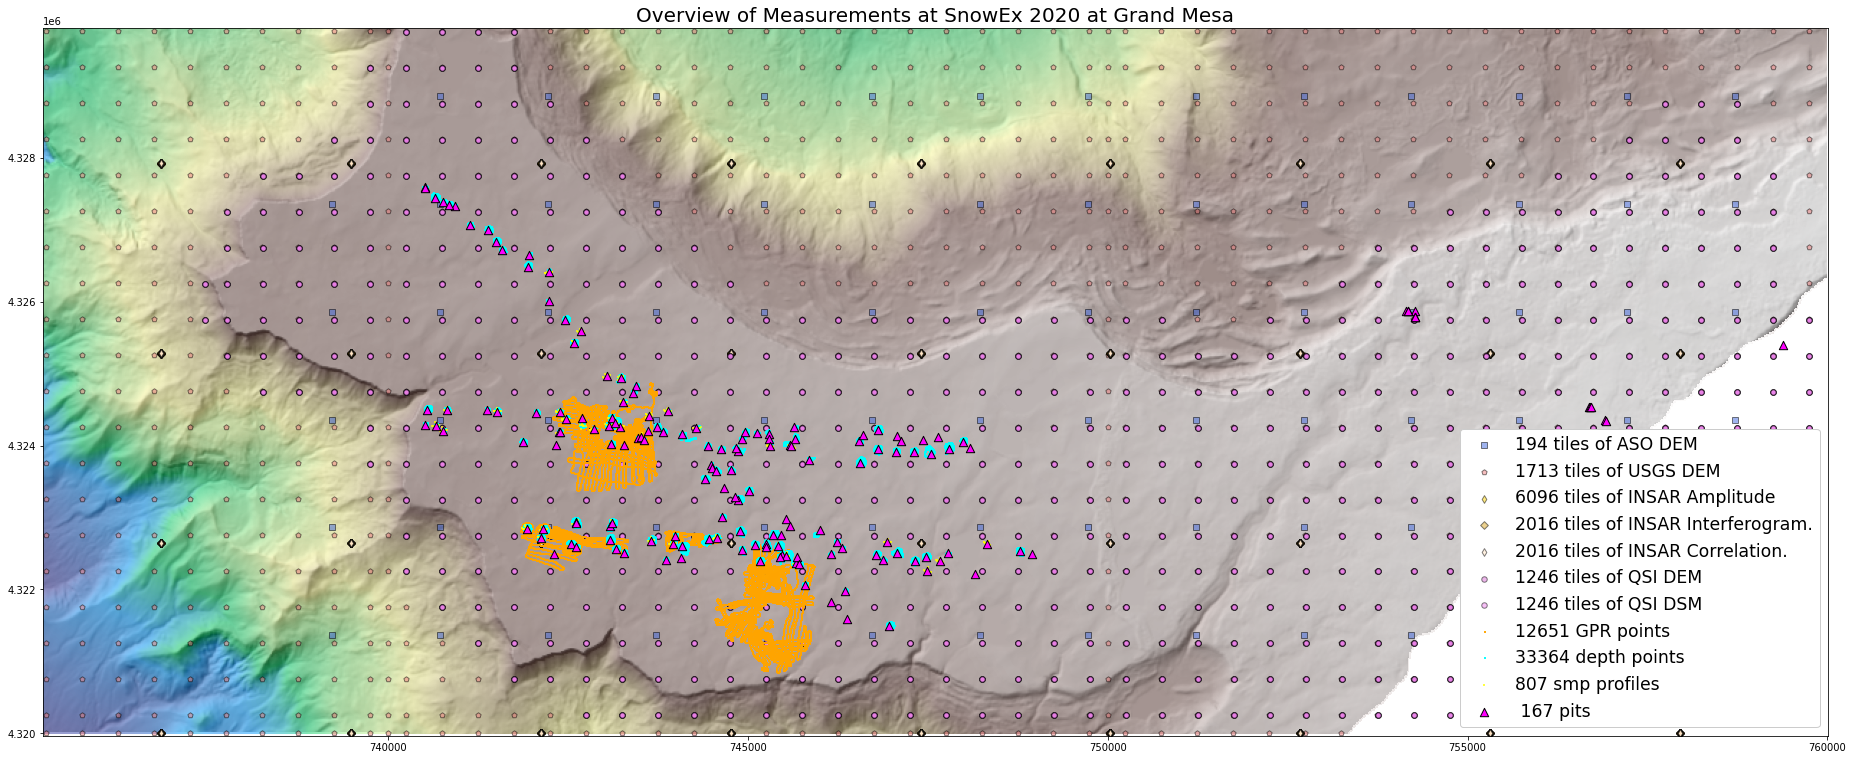

In [37]:
fig, ax = plt.subplots(1,1, figsize=(32, 16))
show(hillshade, ax=ax, cmap='gray', transform=hillshade.transform)
show(dem, ax=ax, alpha=0.5, cmap='terrain', transform=dem.transform)

# Plot raster centers 
for n, d in tiles.items():
    df = d[0]
    color = d[1]
    marker = d[2]
    ind = df.geometry.within(extent)
    df.loc[ind].plot(ax=ax, marker=marker, markersize=30, edgecolor='black', alpha=0.5,  color=color, label='{} tiles of {}'.format(len(df.index), n))

# Add in the other point data
gpr.plot(ax=ax, marker=',' , color='orange', markersize=1, label='{} GPR points'.format(len(gpr.index)))
depths.plot(ax=ax, marker=',' , color='aqua', markersize=1, label='{} depth points'.format(len(depths.index)))
smp.plot(ax=ax, marker='|' , color='yellow', markersize=5, label='{} smp profiles'.format(len(smp.index)))
pits.plot(ax=ax, marker='^' , color='magenta', edgecolor='black', markersize=70, label=' {} pits'.format(len(pits.index)))
ax.legend(loc='lower right', fontsize='xx-large', framealpha=1.0)
ax.set_title('Overview of Measurements at SnowEx 2020 at Grand Mesa', size=20)
#plt.savefig('/SOME/LOCATION/')
